In [889]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver
from icp import best_fit_transform
import pickle

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Generate motors

In [728]:
def create_motors(n_motors=10, d_lims=(0,2), th_lims=(0,pi)):
    motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(*d_lims)).trs() * 
               vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(*th_lims) * -0.5)) 
              for i in range(n_motors)]
    return motors

In [21]:
def create_points(motor, gaussian=False, radius=10, n_points=10, points_std=0.8, noise_std=0.09):
    points = []
    for i in range(n_points):
        if gaussian:
            a = vsr.Vec(*np.random.normal(0.0, points_std,3)).null()
        else:
            a = (vsr.Vec(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(0,radius)).null()
        b = a.spin(motor)
        t = vsr.Vec(*np.random.random(3)).unit() * np.random.normal(0.0,noise_std,1)
        noise_motor = t.trs() * vsr.Rot(1,0,0,0)
        bn = a.spin(noise_motor).spin(motor)
#         bn = vsr.Vec(*(np.array(a)[:3] + np.random.normal(0,noise_std,3))).null().spin(motor)
        points.append((a,b,bn))

    return (points, motor)

In [22]:
def estimate_motors_lars(dataset, noisy=False):
    points, motor = dataset
    
    def solve(L):
        Lrr = L[:4, :4]
        Lrq = L[:4, 4:]
        Lqr = L[4:, :4]
        Lqq = L[4:, 4:]
        Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
        w, v = np.linalg.eig(Lp)
        r = v[:, np.argmin(w)]
        q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
        return vsr.Mot(*np.array([r, q]).ravel())

    Q = np.zeros((8,8))
    inf = vsr.CGA(*[0]*32); inf[5] = 1.0
        
    points_a = []
    points_b = []
    points_bn = []
    for (a,b,bn) in points:
        points_a.append(vsr.CGA(a) ^ inf)
        points_b.append(vsr.CGA(b) ^ inf)
        points_bn.append(vsr.CGA(bn) ^ inf)
        
#         points_a.append(vsr.CGA(a))
#         points_b.append(vsr.CGA(b))
#         points_bn.append(vsr.CGA(bn))
        
    if noisy:
        for b,a in zip(points_a, points_bn):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)
    else:
        for b,a in zip(points_a, points_b):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)
    converged = True
    estimated_motor = solve(Q)
    
    if np.sign(estimated_motor[0]) != np.sign(motor[0]):
        estimated_motor = estimated_motor * -1.0
        
    return (converged, (points, motor, estimated_motor, _))

# Translation invariance

In [23]:
ps, motor = create_points(create_motors(1)[0])
m2 = vsr.Vec(1,2,3).trs() * vsr.Rot(1,0,0,0)
ds = [np.inner(np.array(a) - np.array(b),np.array(a) - np.array(b)) for a,b,bn in ps]
np.sum(ds)

831.78098304162563

In [6]:
ds = [np.inner(np.array(a.spin(m2)) - np.array(b.spin(m2)),
               np.array(a.spin(m2)) - np.array(b.spin(m2))) for a,b,bn in ps]
np.sum(ds)

12564.238146410205

In [7]:
def estimate_motors(dataset, 
                    noisy=False):
    
    points, motor = dataset
#     if noisy:
#         initial_motor = motor
#     else:
#         initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        
    _, d = estimate_motors_lars(dataset, noisy)
    _, _, initial_motor, _ = d
    
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in points:
            mes.add_point_correspondences_residual_block(a,bn)
    else:
        for (a, b, _) in points:
            mes.add_point_correspondences_residual_block(a,b)
#     mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.set_parameterization('POLAR_DECOMPOSITION_TANGENT')
    mes.linear_solver_type = 'DENSE_QR'
    mes.max_num_iterations=20
    (estimated_motor, summary, _) = mes.solve()
    if len(pd.DataFrame(summary['iterations'])['cost']) > 20:
        converged = False
    else:
        converged = True
    return (converged, (points, motor, estimated_motor, summary))

In [8]:
def estimate_motors_vd(dataset, 
                       initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                       noisy=False):
    vd = VDMotorEstimationSolver()
    points, motor = dataset
    points_a = []
    points_b = []
    points_bn = []
    for (a,b,bn) in points:
        points_a.append(a)
        points_b.append(b)
        points_bn.append(bn)
    if noisy:
        vd.add_point_observations(points_a, points_bn)
    else:
        vd.add_point_observations(points_a, points_b)
    estimated_motor = vd.solve()
    converged = True
    return (converged, (points, motor, estimated_motor, []))

In [9]:
def estimate_motors_svd(dataset, 
                        initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                        noisy=False):
    def log(R):
        # Rotation matrix logarithm
        theta = np.arccos((R[0,0] + R[1,1] + R[2,2] - 1.0)/2.0)
        return np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]]) * theta / (2*np.sin(theta))
    points, motor = dataset
    points_a_np = []
    points_b_np = []
    points_bn_np = []
    for (a,b,bn) in points:
        points_a_np.append(np.array(a.vec()))
        points_b_np.append(np.array(b.vec()))
        points_bn_np.append(np.array(bn.vec()))
    points_a_np = np.array(points_a_np)
    points_b_np = np.array(points_b_np)
    points_bn_np = np.array(points_bn_np)
    if noisy:
        T, R, t = best_fit_transform(points_a_np, points_bn_np)
        estimated_motor = vsr.Vec(*t).trs() * vsr.Rot(vsr.Vec(*(log(R) * 0.5)).unduale())
    else:
        T, R, t = best_fit_transform(points_a_np, points_b_np)
        estimated_motor = vsr.Vec(*t).trs() * vsr.Rot(vsr.Vec(*(log(R) * 0.5)).unduale())
    converged = True
    return (converged, (points, motor, estimated_motor, []))  

In [10]:
motors = create_motors(1)
datasets = [create_points(motor, n_points=3, radius=1, gaussian=False, noise_std=0.18) for motor in motors]
converged, data = estimate_motors(datasets[0], noisy=True)
points, motor, estimated_motor, summary = data
points_a, points_b, points_b_noisy = points
point_radius = 0.04
scene = Scene(children=
              [point_mesh(point, radius=point_radius,color=Colors.HOTPINK) for point, _,_ in points] +\
              [point_mesh(point, radius=point_radius,color=Colors.LIGHTSKYBLUE) for _,point,_ in points] +\
              [point_mesh(point, radius=point_radius,color=Colors.GRAY) for _,_,point in points] +\
              [point_mesh(point.spin(estimated_motor), radius=point_radius,color=Colors.RED) for point,_,_ in points] +\
              [frame_mesh(size=0.5)] +\
              [AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[0, 5, 5], up=[0, 0, 1],
                      children=[DirectionalLight(color='white', 
                                                 position=[3, 5, 1], 
                                                 intensity=0.5)])


renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
# display(renderer)

# Estimate motors using all methods

In [11]:
def run(n_points, n_sets=10, n_motors=10, noise_std=0.09, points_std=0.08, noisy=False):
    motors = create_motors(n_motors)
    setofsets = [[create_points(motor, noise_std=noise_std) for i in range(n_sets)] for motor in motors]
    results = []
    results_vd = []
    results_svd = []
    
    for set_ in setofsets:
        for el in set_:
            converged, _ = estimate_motors(el, noisy=noisy)
            if converged:
                results.append(estimate_motors_lars(el, noisy=noisy)[1])
                results_vd.append(estimate_motors_vd(el, noisy=noisy)[1])
                results_svd.append(estimate_motors_svd(el, noisy=noisy)[1])
    return (results, results_vd, results_svd)  

In [34]:
def rms(results):
    rms_dists_true = []
    rms_dists_data = []
    for result in results:
        (ps, m, em, s) = result
        dstrue = [b.vec() - a.spin(em).vec() for a,b,bn in ps]
#         dstrue = [b.vec() - bn.vec() for a,b,bn in ps]
        dsdata = [bn.vec() - a.spin(em).vec() for a,b,bn in ps]
        n = len(dstrue)
        rms_dists_true.append(np.sqrt(np.sum([np.inner(d,d) for d in dstrue]) / n)) 
        rms_dists_data.append(np.sqrt(np.sum([np.inner(d,d) for d in dsdata]) / n)) 

    true = np.mean(rms_dists_true), np.std(rms_dists_true)
    data = np.mean(rms_dists_data), np.std(rms_dists_data)
    return (true, data)

In [36]:
motor.trs()

Vec: [ 0.036 0.43 0.42 ]

In [742]:
def rms_motor(results):
    rms_rot = []
    rms_mot = []
    rms_trs = []
    for result in results:
        (_, m, em, _) = result
#         print(m)
        
#         rot_error = np.min([np.linalg.norm(np.array(m.rot()) - np.array(em.rot())),
#                       np.linalg.norm(np.array(m.rot()) + np.array(em.rot()))])
#         rot = np.inner(rot_error, rot_error)
        
        emm = em.rev() * m
        angle_error = 2 * np.arccos(np.abs(emm[0]))
        rot = angle_error**2
        
#         angle_error = 2 * np.arccos(np.abs(m[0])) - 2 * np.arccos(np.abs(em[0]))
#         rot = angle_error**2
#         print(rot)
    
#         d = emm.trs()
#         print(m)
#         print(em)
#         print(m.trs())
#         print(em.trs())
#         print(m.trs() - em.trs())
#         print()
        d = emm.trs()
#         d = np.array(m.trs() - em.trs())
        trs = np.inner(d,d)
        
        rl = m.rot()
        erl = em.rot()
        rerr = np.array((rl * erl.rev()).log())
        t = m.trs()
        et = em.trs()
        terr = np.array(t - et)
        
#         mot = np.linalg.norm(m * em.rev()) - 1.0
        
        rms_mot.append(np.inner(rerr,rerr) + np.inner(terr,terr))
        rms_rot.append(rot)
        rms_trs.append(trs)
        
#         print('m_during: ', m)
        
#     print()
        

    motmean = np.mean(rms_mot)
#     rotmean = np.mean(rms_rot)
    rotmean = np.sqrt(np.sum(rms_rot) / len(rms_rot))
    trsmean = np.sqrt(np.sum(rms_trs) / len(rms_trs)) 
    return (motmean, rotmean, trsmean)

In [743]:
def compare_rms(results, results_vd, results_svd):
    RMS = {'Ti': {}, "VD": {}, 'AHB':{}}
    our_true, our_data = rms(results)
    Ti = RMS['Ti']
    Ti['$\mu_t$'], Ti['$\sigma_t$'] = our_true
    Ti['$\mu_d$'], Ti['$\sigma_d$'] = our_data
    vd_true, vd_data = rms(results_vd)
    VD = RMS['VD']
    VD['$\mu_t$'], VD['$\sigma_t$'] = vd_true
    VD['$\mu_d$'], VD['$\sigma_d$'] = vd_data
    ahb_true, ahb_data = rms(results_svd)
    AHB = RMS['AHB']
    AHB['$\mu_t$'], AHB['$\sigma_t$'] = ahb_true
    AHB['$\mu_d$'], AHB['$\sigma_d$'] = ahb_data

    return pd.DataFrame(RMS)

In [744]:
def compare_rms_motor_points(results, results_vd, results_ahb):
    RMS = {'Ti': {}, "VD": {}, 'AHB':{}}
    our_mot, our_rot, our_trs = rms_motor(results)
    Ti = RMS['Ti']
    Ti['mot'] = our_mot
    Ti['rot'] = our_rot
    Ti['trs'] = our_trs
    vd_mot, vd_rot, vd_trs = rms_motor(results_vd)
    VD = RMS['VD']
    VD['mot'] = vd_mot
    VD['rot'] = vd_rot
    VD['trs'] = vd_trs
    ahb_mot, ahb_rot, ahb_trs = rms_motor(results_ahb)
    AHB = RMS['AHB']
    AHB['mot'] = ahb_mot
    AHB['rot'] = ahb_rot
    AHB['trs'] = ahb_trs
    return pd.DataFrame(RMS)

In [745]:
noise_levels = np.linspace(0.0,pi,10)
noise_levels = [0.001, 0.005, 0.01]
rmss = [compare_rms(*run(32,32,32,noise_std=noise_level,noisy=True)) 
        for noise_level in noise_levels]

In [736]:
d = pd.concat(rmss)
d

,AHB,Ti,VD
$\mu_d$,0.000873,0.000873,0.000873
$\mu_t$,0.000410,0.000410,0.000410
$\sigma_d$,0.000200,0.000200,0.000200
$\sigma_t$,0.000168,0.000168,0.000168
$\mu_d$,0.004355,0.004355,0.004355
$\mu_t$,0.002071,0.002071,0.002071
$\sigma_d$,0.001066,0.001066,0.001066
$\sigma_t$,0.000810,0.000810,0.000810
$\mu_d$,0.008770,0.008770,0.008770
$\mu_t$,0.004185,0.004185,0.004185


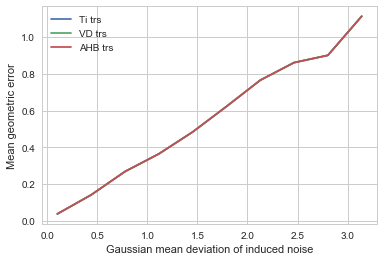

In [400]:
fig, ax = plt.subplots(1)
# ax.plot(noise_levels, noise_levels, marker='.')
# ax.plot(noise_levels, d['Ti']['rot'], label='Ti rot')
# ax.plot(noise_levels, d['Ti']['mot'], label='Ti mot')
ax.plot(noise_levels, d['Ti']['trs'], label='Ti trs')
# ax.plot(noise_levels, d['VD']['rot'], label='VD rot')
# ax.plot(noise_levels, d['VD']['mot'], label='VD mot')
ax.plot(noise_levels, d['VD']['trs'], label='VD trs')
# ax.plot(noise_levels, d['AHB']['rot'], label='AHB rot')
# ax.plot(noise_levels, d['AHB']['mot'], label='AHB mot')
ax.plot(noise_levels, d['AHB']['trs'], label='AHB trs')
ax.legend(frameon=False, loc=2)
ax.set_ylabel('Mean geometric error')
ax.set_xlabel('Gaussian mean deviation of induced noise')
# fig.savefig('/Users/lars/latex/latex-phd-thesis/Figures/points-est-deviation.pdf')

In [ ]:
# pickle.dump(rmss, open('rmss.pickle', 'wb'))

# Analyze iterations

In [ ]:
results, results_vd_its, results_svd_its = run(n_points=100, n_sets=100, n_motors=100)
results_noisy, results_vd_its_noisy, results_svd_its_noisy = run(n_points=100, n_sets=100, n_motors=100, noisy=True)
summaries = [result[3] for result in results]
summaries_noisy = [result[3] for result in results_noisy]
iteration_numbers = []
iteration_numbers_noisy = []
for summary in summaries:
    iteration_numbers.append(len(pd.DataFrame(summary['iterations'])['cost']))
for summary in summaries_noisy:
    iteration_numbers_noisy.append(len(pd.DataFrame(summary['iterations'])['cost']))

In [ ]:
median = np.median(iteration_numbers)
argmedian = np.where([iteration_numbers == median])[1]
# print(argmedian)
print(median)
argmax = np.argmax(iteration_numbers)
print(np.max(iteration_numbers))
# print(argmax)
argmin = np.argmin(iteration_numbers)
# print(argmin)
print(np.min(iteration_numbers))

In [ ]:
median_noisy = np.median(iteration_numbers_noisy)
print(median_noisy)
argmax_noisy = np.argmax(iteration_numbers_noisy)
print(argmax_noisy)
print(np.max(iteration_numbers_noisy))
argmin_noisy = np.argmin(iteration_numbers_noisy)
print(argmin_noisy)
print(np.min(iteration_numbers_noisy))

In [ ]:
_,argmedian_noisy = np.where([iteration_numbers_noisy == median_noisy])
argmedian_noisy = argmedian_noisy[0]
print(argmedian_noisy)

In [ ]:
print(results_noisy[argmax_noisy][1])
print(results_noisy[argmax_noisy][2])

In [ ]:
print(results_noisy[argmedian_noisy][1])
print(results_noisy[argmedian_noisy][2])

In [ ]:
print(results_vd_its_noisy[argmax_noisy][1])
print(results_vd_its_noisy[argmax_noisy][2])

In [ ]:
print(results_noisy[argmedian_noisy][2])
print(results_vd_its_noisy[argmedian_noisy][1])
print(results_svd_its_noisy[argmedian_noisy][2])

In [ ]:
results_svd_its_noisy[argmax_noisy][2] * results_noisy[argmax_noisy][2].rev()

In [ ]:
results_svd_its_noisy[argmax_noisy][2].matrix()

In [ ]:
results_noisy[argmax_noisy][2].matrix()

In [ ]:
# motors = create_motors(1)
# datasets = [create_points(motor, n_points=3, radius=1, gaussian=False, noise_std=0.075) for motor in motors]
points, motor, estimated_motor, summary = results_noisy[argmax_noisy]
points, motor, estimated_motor2, summary = results_vd_its_noisy[argmax_noisy]

point_radius = 0.04
scene = Scene(children=
              [point_mesh(point, radius=point_radius,color=Colors.HOTPINK) for point, _,_ in points] +\
              [point_mesh(point, radius=point_radius,color=Colors.LIGHTSKYBLUE) for _,point,_ in points] +\
#               [point_mesh(point, radius=point_radius,color=Colors.GRAY) for _,_,point in points] +\
              [point_mesh(point.spin(estimated_motor), radius=point_radius,color=Colors.AQUAMARINE)
               for point,_,_ in points] +\
              [point_mesh(point.spin(estimated_motor2), radius=point_radius,color=Colors.RED)
               for point,_,_ in points] +\
              [frame_mesh(size=0.5)] +\
              [AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[0, 5, 5], up=[0, 0, 1],
                      children=[DirectionalLight(color='white', 
                                                 position=[3, 5, 1], 
                                                 intensity=0.5)])


renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
# display(renderer)

# Estimate motors from line observations

In [802]:
def create_random_lines(motor, n_lines=10, radius=10, 
                        trs_noise_std=0.09, rot_noise_std=0.09):
    lines = []
    for i in range(n_lines):
        
        if trs_noise_std > 0.0:
            t = vsr.Vec(*np.random.random(3)).unit() * np.random.normal(0.0,trs_noise_std,1)
        else:
            t = vsr.Vec(0,0,0)
            
        if rot_noise_std > 0.0:
            R = vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * 
                            np.random.normal(0, rot_noise_std) * -0.5)
        else:
            R = vsr.Rot(1,0,0,0)
        noise_motor = t.trs() * R
        
        p = (vsr.Vec(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(0,radius))
        
        v = vsr.Vec(*np.random.uniform(-1,1,3)).unit()
        
        mp = p.trs() * vsr.Rot(1,0,0,0)
        a = vsr.Dll(vsr.Vec(0,0,0).null(),v)
        an = a.spin(noise_motor)
        
        a = a.spin(mp)
        an = an.spin(mp)
        
#         a = vsr.Dll(p.null(), v)
#         an = a.spin(noise_motor)

        b = a.spin(motor)
        bn = an.spin(motor)
        lines.append((a,b,bn))
    return (lines, motor)

In [885]:
def estimate_motors_lines(dataset, 
                          initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                          noisy=False,
                          onlyrot=False
                         ):
    lines, motor = dataset
    
    _, _, initial_motor, _ = estimate_motors_lines_daniilidis(dataset, noisy=noisy)

#     initial_motor = vsr.CGA(motor).spin(vsr.CGA(vsr.Vec(0,0,0).trs() * vsr.Rot(vsr.Biv(pi/4,0,0)))).mot()
    
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in lines:
            if onlyrot:
#                 mes.add_line_commutator_residual_block(a,bn)
                mes.add_line_correspondences_residual_block(a,bn)
            else:
                mes.add_line_commutator_residual_block(a,bn)
    else:
        for (a, b, _) in lines:
            if onlyrot:
#                 mes.add_line_commutator_residual_block(a,b)
                mes.add_line_correspondences_residual_block(a,b)
            else:
                mes.add_line_commutator_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    
    

    
    return (lines, motor, estimated_motor, summary)

In [868]:
def estimate_motors_lines_vd(dataset, 
                             initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                             noisy=False):
    vd = VDMotorEstimationSolver()
    lines, motor = dataset
    lines_a = []
    lines_b = []
    lines_bn = []
    for (a,b,bn) in lines:
        lines_a.append(a)
        lines_b.append(b)
        lines_bn.append(bn)
    if noisy:
        vd.add_dual_line_observations(lines_a, lines_bn)
    else:
        vd.add_dual_line_observations(lines_a, lines_b)
    estimated_motor = vd.solve()
    return (lines, motor, estimated_motor, [])

In [869]:
def daniilidis_motor(LAs, LBs):
    Ds = []
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((8,8))
        for i in range(8):
            ei = vsr.Mot(0,0,0,0,0,0,0,0)
            ei[i] = 1.0
            D[:,i] = np.array(ei * LA - LB * ei)
        Ds.append(D[1:7,:].copy())

    
    Ds = np.array(Ds).reshape(-1,8)
    [U, s, Vt] = np.linalg.svd(Ds)

    v7 = Vt.T[:,-2].copy()
    v8 = Vt.T[:,-1].copy()
    
    v7 = np.array([v7[0], v7[3], -v7[2], v7[1], -v7[7],v7[4], v7[5], v7[6]])
    v8 = np.array([v8[0], v8[3], -v8[2], v8[1], -v8[7],v8[4], v8[5], v8[6]])
    
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]

    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])

    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1./val)
    lambda1 = s * lambda2
    
    m_arr = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]

    return vsr.Mot(*m_arr)

In [870]:
def estimate_motors_lines_daniilidis(dataset, 
                             initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                             noisy=False):
    lines, motor = dataset
    lines_a = []
    lines_b = []
    lines_bn = []
    for (a,b,bn) in lines:
        lines_a.append(a)
        lines_b.append(b)
        lines_bn.append(bn)
    if noisy:
        estimated_motor = daniilidis_motor(lines_a, lines_bn)
    else:
        estimated_motor = daniilidis_motor(lines_a, lines_b)
        
    if np.sign(estimated_motor[0]) != np.sign(motor[0]):
        estimated_motor = estimated_motor * -1.0
    return (lines, motor, estimated_motor, [])

In [871]:
def estimate_motors_lines_lars(dataset, noisy=False):
    lines, motor = dataset
    
    def solve(L):
        Lrr = L[:4, :4]
        Lrq = L[:4, 4:]
        Lqr = L[4:, :4]
        Lqq = L[4:, 4:]
        Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
        w, v = np.linalg.eig(Lp)
        r = v[:, np.argmin(w)]
        q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
        return vsr.Mot(*np.array([r, q]).ravel())

    Q = np.zeros((8,8))
        
    lines_a = []
    lines_b = []
    lines_bn = []
    for (a,b,bn) in lines:
        lines_a.append(vsr.CGA(a))
        lines_b.append(vsr.CGA(b))
        lines_bn.append(vsr.CGA(bn))
        
    if noisy:
        for b,a in zip(lines_a, lines_bn):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)
    else:
        for b,a in zip(lines_a, lines_b):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)

    estimated_motor = solve(Q)
    
    if np.sign(estimated_motor[0]) != np.sign(motor[0]):
        estimated_motor = estimated_motor * -1.0
        
    return (lines, motor, estimated_motor, _)

In [974]:
def run_lines(n_lines=10, n_sets=10, n_motors=10, trs_noise_std=0.09, rot_noise_std=0.09,
              noisy=False, onlyrot=True, radius=2, d_lims=(0,2), th_lims=(0,pi)):
#     thlim = pi/2
    motors = create_motors(n_motors, d_lims=d_lims, th_lims=th_lims)
    results = []
    results_vd = []
    results_daniilidis = []
    results_comm = []
        
    for motor in motors:
        datasets = [create_random_lines(motor, n_lines, 
                                    rot_noise_std=rot_noise_std, 
                                    trs_noise_std=trs_noise_std,
                                       radius=radius) 
                for n_set in range(n_sets)]
        
        for dataset in datasets:
            results.append(estimate_motors_lines(dataset, noisy=noisy, onlyrot=onlyrot))
            results_vd.append(estimate_motors_lines_vd(dataset, noisy=noisy))
            results_daniilidis.append(estimate_motors_lines_daniilidis(dataset, noisy=noisy))
            results_comm.append(estimate_motors_lines(dataset, noisy=noisy, onlyrot=False))
            

    return (results, results_vd, results_daniilidis, results_comm)

In [975]:
def compare_rms_lines(results, results_vd, results_bds, results_comm):
    RMS = {'Ti': {}, "VD": {}, 'BDS':{}, 'TiComm': {}}
    our_mot, our_rot, our_trs = rms_motor(results)
    Ti = RMS['Ti']
    Ti['rot'] = our_rot
    Ti['mot'] = our_mot
    Ti['trs'] = our_trs
    our_comm_mot, our_comm_rot, our_comm_trs = rms_motor(results_comm)
    TiComm = RMS['TiComm']
    TiComm['rot'] = our_comm_rot
    TiComm['mot'] = our_comm_mot
    TiComm['trs'] = our_comm_trs
    vd_mot, vd_rot, vd_trs = rms_motor(results_vd)
    VD = RMS['VD']
    VD['rot'] = vd_rot
    VD['mot'] = vd_mot
    VD['trs'] = vd_trs
    bds_mot, bds_rot, bds_trs = rms_motor(results_bds)
    BDS = RMS['BDS']
    BDS['rot'] = bds_rot
    BDS['mot'] = bds_mot
    BDS['trs'] = bds_trs
    return pd.DataFrame(RMS)

# Near the origin - constant translation noise

In [976]:
sns.set_context('paper')

In [977]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1, n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)
rmss_lines_rot_noise = [compare_rms_lines(*run_lines(10,10,10, 
                                               rot_noise_std=noise_level_rot, 
                                               trs_noise_std=0.001, noisy=True,
                                               onlyrot=True, 
                                               radius=2)) 
              for noise_level_rot, 
                  noise_level_trs in zip(noise_levels_rot, noise_levels_trs)]


## Rotation and translation plot

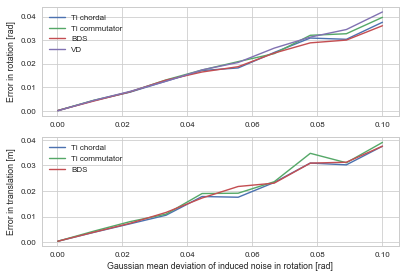

In [978]:
d = pd.concat(rmss_lines_rot_noise)

fig, ax = plt.subplots(2)

ax0 = ax[0]
ax0.plot(noise_levels_rot, d['Ti']['rot'].tolist(), label='Ti chordal')
ax0.plot(noise_levels_rot, d['TiComm']['rot'].tolist(), label='Ti commutator')
ax0.plot(noise_levels_rot, d['BDS']['rot'].tolist(), label='BDS')
ax0.plot(noise_levels_rot, d['VD']['rot'].tolist(), label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')

ax1 = ax[1]
ax1.plot(noise_levels_rot, d['Ti']['trs'].tolist(), label='Ti chordal')
ax1.plot(noise_levels_rot, d['TiComm']['trs'].tolist(), label='Ti commutator')
ax1.plot(noise_levels_rot, d['BDS']['trs'].tolist(), label='BDS')
ax1.legend(frameon=False, loc=2)

ax1.set_xlabel('Gaussian mean deviation of induced noise in rotation [rad]')
ax1.set_ylabel('Error in translation [m]')

# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/lines-near-rot-noise.pdf')

# Near the origin - constant rotation noise

In [979]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1, n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)
rmss_lines_trs_noise = [compare_rms_lines(*run_lines(10,10,10, 
                                               rot_noise_std=0.001, 
                                               trs_noise_std=noise_level_trs, 
                                                     noisy=True,
                                               onlyrot=True, 
                                               radius=2)) 
              for noise_level_rot, 
                  noise_level_trs in zip(noise_levels_rot, noise_levels_trs)]

## Rotation and translation plot

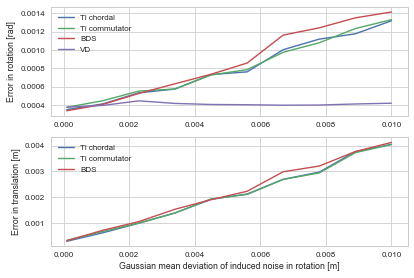

In [980]:
d = pd.concat(rmss_lines_trs_noise)
fig, ax = plt.subplots(2)
ax0 = ax[0]
ax0.plot(noise_levels_trs, d['Ti']['rot'].tolist(), label='Ti chordal')
ax0.plot(noise_levels_trs, d['TiComm']['rot'].tolist(), label='Ti commutator')
ax0.plot(noise_levels_trs, d['BDS']['rot'].tolist(), label='BDS')
ax0.plot(noise_levels_trs, d['VD']['rot'].tolist(), label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')

ax1 = ax[1]
ax1.plot(noise_levels_trs, d['Ti']['trs'].tolist(),   label='Ti chordal')
ax1.plot(noise_levels_trs, d['TiComm']['trs'].tolist(),label='Ti commutator')
ax1.plot(noise_levels_trs, d['BDS']['trs'].tolist(), label='BDS')
ax1.legend(frameon=False, loc=2)

ax1.set_xlabel('Gaussian mean deviation of induced noise in rotation [m]')
ax1.set_ylabel('Error in translation [m]')
# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/lines-near-trs-noise.pdf')

# Near the origin - increasing both rotation and translation

In [981]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1, n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)
rmss_lines_rot_trs_noise = [compare_rms_lines(*run_lines(10,10,10, 
                                               rot_noise_std=noise_level_rot, 
                                               trs_noise_std=noise_level_trs, 
                                                     noisy=True,
                                               onlyrot=True, 
                                               radius=2)) 
              for noise_level_rot, 
                  noise_level_trs in zip(noise_levels_rot, noise_levels_trs)]

## Rotation and translation plot

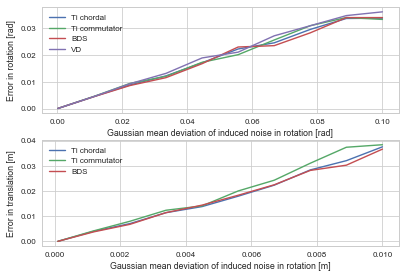

In [982]:
d = pd.concat(rmss_lines_rot_trs_noise)
fig, ax = plt.subplots(2)
ax0 = ax[0]
ax0.plot(noise_levels_rot, d['Ti']['rot'].tolist(), label='Ti chordal')
ax0.plot(noise_levels_rot, d['TiComm']['rot'].tolist(), label='Ti commutator')
ax0.plot(noise_levels_rot, d['BDS']['rot'].tolist(), label='BDS')
ax0.plot(noise_levels_rot, d['VD']['rot'].tolist(), label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')
ax0.set_xlabel('Gaussian mean deviation of induced noise in rotation [rad]')

ax1 = ax[1]
ax1.plot(noise_levels_trs, d['Ti']['trs'].tolist(),   label='Ti chordal')
ax1.plot(noise_levels_trs, d['TiComm']['trs'].tolist(),label='Ti commutator')
ax1.plot(noise_levels_trs, d['BDS']['trs'].tolist(), label='BDS')
ax1.legend(frameon=False, loc=2)

fig.subplots_adjust(hspace=.25)

ax1.set_xlabel('Gaussian mean deviation of induced noise in rotation [m]')
ax1.set_ylabel('Error in translation [m]')
# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/lines-near-trs-rot-noise.pdf')

# Far from the origin - constant translation noise

In [1021]:
radius = 10

In [1022]:
sns.set_context('paper')

In [1023]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1, n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)
rmss_lines_rot_noise = [compare_rms_lines(*run_lines(10,10,10, 
                                               rot_noise_std=noise_level_rot, 
                                               trs_noise_std=0.001, noisy=True,
                                               onlyrot=True, 
                                               radius=radius)) 
              for noise_level_rot, 
                  noise_level_trs in zip(noise_levels_rot, noise_levels_trs)]


## Rotation and translation plot

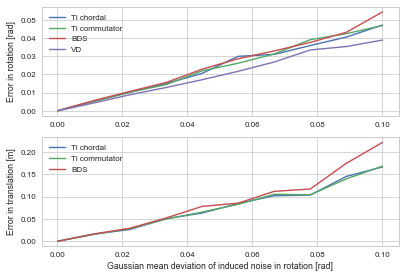

In [1024]:
d = pd.concat(rmss_lines_rot_noise)

fig, ax = plt.subplots(2)

ax0 = ax[0]
ax0.plot(noise_levels_rot, d['Ti']['rot'].tolist(), label='Ti chordal')
ax0.plot(noise_levels_rot, d['TiComm']['rot'].tolist(), label='Ti commutator')
ax0.plot(noise_levels_rot, d['BDS']['rot'].tolist(), label='BDS')
ax0.plot(noise_levels_rot, d['VD']['rot'].tolist(), label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')

ax1 = ax[1]
ax1.plot(noise_levels_rot, d['Ti']['trs'].tolist(), label='Ti chordal')
ax1.plot(noise_levels_rot, d['TiComm']['trs'].tolist(), label='Ti commutator')
ax1.plot(noise_levels_rot, d['BDS']['trs'].tolist(), label='BDS')
ax1.legend(frameon=False, loc=2)

ax1.set_xlabel('Gaussian mean deviation of induced noise in rotation [rad]')
ax1.set_ylabel('Error in translation [m]')

# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/lines-far-rot-noise.pdf')

# Far from the origin - constant rotation noise

In [1025]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1, n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)
rmss_lines_trs_noise = [compare_rms_lines(*run_lines(10,10,10, 
                                               rot_noise_std=0.001, 
                                               trs_noise_std=noise_level_trs, 
                                                     noisy=True,
                                               onlyrot=True, 
                                               radius=radius)) 
              for noise_level_rot, 
                  noise_level_trs in zip(noise_levels_rot, noise_levels_trs)]

## Rotation and translation plot

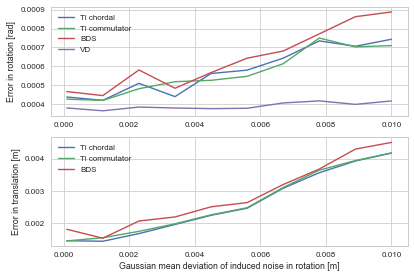

In [1026]:
d = pd.concat(rmss_lines_trs_noise)
fig, ax = plt.subplots(2)
ax0 = ax[0]
ax0.plot(noise_levels_trs, d['Ti']['rot'].tolist(), label='Ti chordal')
ax0.plot(noise_levels_trs, d['TiComm']['rot'].tolist(), label='Ti commutator')
ax0.plot(noise_levels_trs, d['BDS']['rot'].tolist(), label='BDS')
ax0.plot(noise_levels_trs, d['VD']['rot'].tolist(), label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')

ax1 = ax[1]
ax1.plot(noise_levels_trs, d['Ti']['trs'].tolist(),   label='Ti chordal')
ax1.plot(noise_levels_trs, d['TiComm']['trs'].tolist(),label='Ti commutator')
ax1.plot(noise_levels_trs, d['BDS']['trs'].tolist(), label='BDS')
ax1.legend(frameon=False, loc=2)

ax1.set_xlabel('Gaussian mean deviation of induced noise in rotation [m]')
ax1.set_ylabel('Error in translation [m]')
plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/lines-far-trs-noise.pdf')

# Far from the origin - increasing both rotation and translation

In [1027]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0001, 0.1, n_noise_levels)
noise_levels_trs = np.linspace(0.0001, 0.01, n_noise_levels)
rmss_lines_rot_trs_noise = [compare_rms_lines(*run_lines(10,10,10, 
                                               rot_noise_std=noise_level_rot, 
                                               trs_noise_std=noise_level_trs, 
                                                     noisy=True,
                                               onlyrot=True, 
                                               radius=radius,
                                                )) 
              for noise_level_rot, 
                  noise_level_trs in zip(noise_levels_rot, noise_levels_trs)]

## Rotation and translation plot

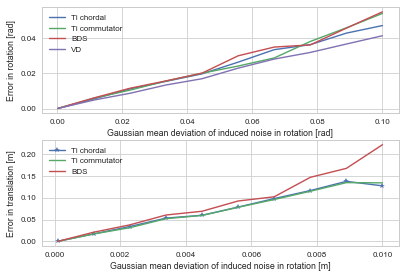

In [1029]:
d = pd.concat(rmss_lines_rot_trs_noise)
fig, ax = plt.subplots(2)
ax0 = ax[0]
ax0.plot(noise_levels_rot, d['Ti']['rot'].tolist(), label='Ti chordal')
ax0.plot(noise_levels_rot, d['TiComm']['rot'].tolist(), label='Ti commutator')
ax0.plot(noise_levels_rot, d['BDS']['rot'].tolist(), label='BDS')
ax0.plot(noise_levels_rot, d['VD']['rot'].tolist(), label='VD')
ax0.legend(frameon=False, loc=2)
ax0.set_ylabel('Error in rotation [rad]')
ax0.set_xlabel('Gaussian mean deviation of induced noise in rotation [rad]')

ax1 = ax[1]
ax1.plot(noise_levels_trs, d['Ti']['trs'].tolist(), marker='*',  label='Ti chordal')
ax1.plot(noise_levels_trs, d['TiComm']['trs'].tolist(),label='Ti commutator')
ax1.plot(noise_levels_trs, d['BDS']['trs'].tolist(), label='BDS')
ax1.legend(frameon=False, loc=2)

fig.subplots_adjust(hspace=.25)

ax1.set_xlabel('Gaussian mean deviation of induced noise in rotation [m]')
ax1.set_ylabel('Error in translation [m]')
# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/lines-far-trs-rot-noise.pdf')

# Translation invariance

In [710]:
lines, m, em, s = run_lines(32,1,1, rot_noise_std=0.3, 
          trs_noise_std=0.03, noisy=True,
                onlyrot=True)[0][0]

print(s['brief_report'])


lines = lines[:3]
scene = Scene(children=
#               [line_mesh(line, color=Colors.HOTPINK) for line, _,_ in lines] +\
              [line_mesh(line, color=Colors.LIGHTSKYBLUE) for _,line,_ in lines] +\
              [line_mesh(line, color=Colors.GRAY) for _,_,line in lines] +\
              [line_mesh(line.spin(em), color=Colors.RED) for line,_,_ in lines] +\
              [frame_mesh(size=1)] +\
              [AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[0, 5, 5], up=[0, 0, 1],
                      children=[DirectionalLight(color='white', 
                                                 position=[3, 5, 1], 
                                                 intensity=0.5)])


renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
display(renderer)

Ceres Solver Report: Iterations: 3, Initial cost: 2.432972e+01, Final cost: 1.039097e+01, Termination: CONVERGENCE


In [584]:
rl = run_lines(10,1,1, rot_noise_std=np.deg2rad(3), 
          trs_noise_std=0.01, noisy=True,
                onlyrot=True)

In [616]:
rl[1][0]

([(Dll: [ 0.3037 0.9527 -0.0113 0.7084 0.633 2.012 ],
   Dll: [ -0.1365 0.9582 -0.2515 0.7458 -0.4951 2.102 ],
   Dll: [ -0.1219 0.9628 -0.2412 0.671 -0.4432 2.173 ]),
  (Dll: [ -0.7309 -0.6243 0.2757 2.169 -2.328 -1.17 ],
   Dll: [ -0.2754 -0.731 0.6243 1.113 -1.558 -1.612 ],
   Dll: [ -0.2983 -0.7347 0.6093 1.077 -1.533 -1.576 ]),
  (Dll: [ 0.4945 -0.8241 0.2763 0.2121 -0.0359 -0.05866 ],
   Dll: [ 0.8496 -0.5055 0.1502 0.5702 -0.2379 0.04078 ],
   Dll: [ 0.8387 -0.5248 0.1453 0.5398 -0.2373 0.05499 ]),
  (Dll: [ -0.02596 -0.9996 0.01023 0.7419 0.002602 0.3926 ],
   Dll: [ 0.3917 -0.9089 0.1432 -0.01977 -0.3306 0.7742 ],
   Dll: [ 0.3779 -0.9167 0.1296 -0.03669 -0.3226 0.7952 ]),
  (Dll: [ -0.3818 0.5124 -0.7692 -2.059 4.12 -1.382 ],
   Dll: [ -0.7871 0.127 -0.6036 -1.476 4.416 0.419 ],
   Dll: [ -0.7786 0.1026 -0.6191 -1.506 4.32 0.6281 ]),
  (Dll: [ 0.1318 0.871 0.4732 2.265 1.929 4.617 ],
   Dll: [ -0.09062 0.9594 0.267 1.302 -0.09326 4.823 ],
   Dll: [ -0.06791 0.9456 0.3181 1.17

In [709]:
print(rl[0][0][2])
print(rl[1][0][2])
print(rl[2][0][2])

Mot: [ 0.96 0.1 -0.19 -0.19 -0.22 -0.62 -0.36 -0.12 ]
Mot: [ 0.96 0.096 -0.18 -0.19 0 0 0 0 ]
Mot: [ 0.96 0.1 -0.19 -0.19 -0.22 -0.62 -0.36 -0.12 ]


In [566]:
wrong_results = []
n1s = []
for (_, m, em, _) in results_lines:
    norm = np.linalg.norm(m * em.rev())
    n1s
    if norm > 1.00001:
        wrong_results.append(((m,em, norm), m.rot() * em.rot().rev()))
print(len(wrong_results))

NameError: name 'results_lines' is not defined

In [123]:
wrong_results

NameError: name 'wrong_results' is not defined

In [33]:
results, _, _ = run_lines(n_lines=100, n_sets=10, n_motors=10)
results_noisy, _, _ = run_lines(n_lines=100, n_sets=10, n_motors=10, noisy=True)
summaries = [result[3] for result in results_lines]
summaries_noisy = [result[3] for result in results_noisy]
iteration_numbers = []
iteration_numbers_noisy = []
for summary in summaries:
    iteration_numbers.append(len(pd.DataFrame(summary['iterations'])['cost']))
for summary in summaries_noisy:
    iteration_numbers_noisy.append(len(pd.DataFrame(summary['iterations'])['cost']))

In [34]:
median = np.median(iteration_numbers)
argmax = np.argmax(iteration_numbers)
argmin = np.argmin(iteration_numbers)

In [36]:
np.max(iteration_numbers)

48

In [1048]:
np.where(iteration_numbers <= np.float64(50))[1]

IndexError: tuple index out of range

In [1045]:
np.max(np.where([iteration_numbers < np.float64(50)])[1])

9999

In [1021]:
median_noisy = np.median(iteration_numbers_noisy)
argmax_noisy = np.argmax(iteration_numbers_noisy)
argmin_noisy = np.argmin(iteration_numbers_noisy)

In [127]:
# fig, ax = plt.subplots(1)
# ax.semilogy(pd.DataFrame(summaries[argmax]['iterations'])['cost'], label='max')
# ax.semilogy(pd.DataFrame(summaries[argmin]['iterations'])['cost'], label='min')
# legend = ax.legend(frameon=False)
# # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xlabel(r'Iteration $k$')
# plt.ylabel(r'Cost')
# plt.savefig('/Users/lars/latex/latex-phd-thesis/Figures/lines-cost-nonoise.pdf')

In [959]:
summaries_lines = [result[3] for result in results_lines]

In [124]:
# k = 19
# print(summaries_lines[k]['full_report'])
# semilogy(pd.DataFrame(summaries_lines[argmax]['iterations'])['cost'])

# Heterogeneous Sets

In [ ]:
def estimate_motors_heterogenepus(dataset, 
                                  initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                                  noisy=False):
    planes, motor = dataset
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in planes:
            mes.add_dual_plane_difference_residual_block(a,bn)
#             mes.add_dual_plane_angle_error_residual_block(a,bn)
    else:
        for (a, b, _) in planes:
#             mes.add_dual_plane_angle_error_residual_block(a,b)
            mes.add_dual_plane_difference_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    return (planes, motor, estimated_motor, summary)

In [147]:
def run_heterogeneous(n_points=10, n_lines=10, n_planes=10, n_sets=10, n_motors=10, noise_std=0.09, points_std=0.08, noisy=False):
    motors = create_motors(n_motors, d_lims=(-1,1), th_lims=(-pi,pi))
    results = []
    results_vd = []
    for n_set in range(n_sets):
        point_datasets = [create_random_planes(motor, n_points, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        line_datasets = [create_random_lines(motor, n_lines, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        plane_datasets = [create_random_planes(motor, n_planes, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        
        for dataset in datasets:
            results.append(estimate_motors_planes(dataset, noisy=noisy))
    return (results, results_vd, results_daniilidis)